# Example climb: Matching means with maximum structural diversity

## 1. Notebook setup

### 1.1. Imports

In [1]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats

sys.path.append('..')

from hill_climber import HillClimber

### 1.2. Run hyperparameters

In [2]:
# Number of input data points
n = 5000

# Run duration in minutes (very short to prevent convergence)
run_time = 60

# Number of replicate climbs (maximum diversity)
replicates = 8

### 1.3. Input distributions

Initial statistics:
Mean w: 10.0112
Mean x: 9.9803
Mean y: 10.0211
Mean z: 10.0330

Initial pairwise KS statistics (similarity):
w-x: 0.0234
w-y: 0.0128
w-z: 0.0160
x-y: 0.0178
x-z: 0.0194
y-z: 0.0122


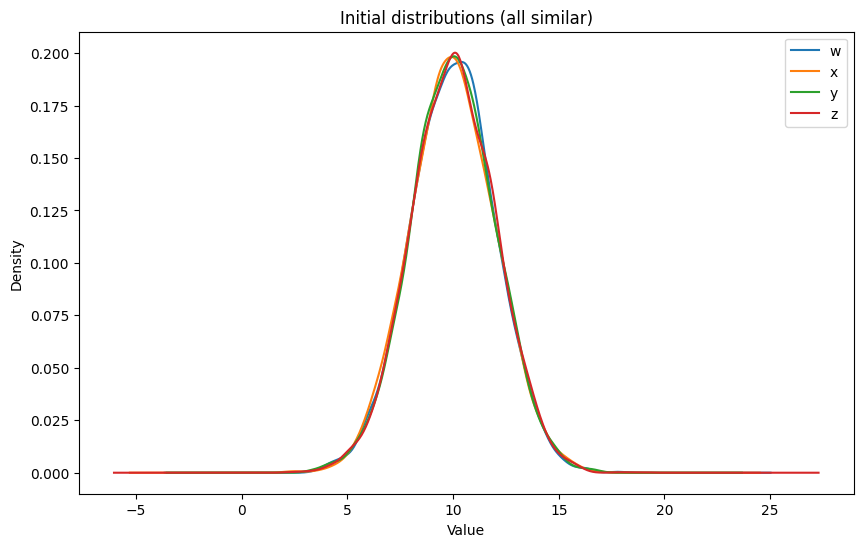

In [3]:
# Create input distributions (4 variables, all strictly positive)
# Start with similar normal distributions that will be evolved into different structures
np.random.seed(42)  # For reproducibility

data = pd.DataFrame({
    'w': np.random.normal(loc=10.0, scale=2.0, size=n),
    'x': np.random.normal(loc=10.0, scale=2.0, size=n),
    'y': np.random.normal(loc=10.0, scale=2.0, size=n),
    'z': np.random.normal(loc=10.0, scale=2.0, size=n)
})

# Ensure all values are strictly positive by clipping any negative values
for col in data.columns:
    data[col] = np.maximum(data[col], 0.1)  # Minimum value of 0.1

print("Initial statistics:")
for col in data.columns:
    print(f"Mean {col}: {np.mean(data[col]):.4f}")

print(f"\nInitial pairwise KS statistics (similarity):")
from itertools import combinations
for col1, col2 in combinations(data.columns, 2):
    ks_stat, _ = stats.ks_2samp(data[col1], data[col2])
    print(f"{col1}-{col2}: {ks_stat:.4f}")

# Visualize using KDE plots to show initial distribution shapes
fig, ax = plt.subplots(figsize=(10, 6))
for col in data.columns:
    data[col].plot.kde(label=col, ax=ax)
plt.title('Initial distributions (all similar)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

## 2. Maximize structural diversity while preserving mean similarity

### 2.1. Objective function

In [4]:
def objective_similar_means_diverse_structures(w, x, y, z):
    '''Maximize structural diversity while maintaining similar means across 4 distributions.
    
    Objective function: mean_ks_statistic - penalty_weight * mean_penalty
    
    This encourages:
        - Similar means across all 4 distributions (w, x, y, z)
        - Maximum structural diversity between distributions (high pairwise KS statistics)
    
    The objective removes standard deviation constraints and focuses purely on:
    1. Mean similarity (penalty for deviation from common mean)
    2. Structural diversity (reward for different distribution shapes)
    
    Args:
        w, x, y, z: Four variables (array-like)
    
    Returns:
        Tuple of (metrics_dict, objective_value) where:
            - metrics_dict: Dict with means, KS statistics, and penalties
            - objective_value: mean_ks_statistic - penalty_weight * mean_penalty
    '''
    
    # Calculate means for all 4 distributions
    means = {
        'w': np.mean(w),
        'x': np.mean(x), 
        'y': np.mean(y),
        'z': np.mean(z)
    }
    
    # Calculate target mean (average of all means)
    target_mean = np.mean(list(means.values()))
    
    # Calculate mean penalty - how far each mean is from the target
    mean_deviations = [abs(mean_val - target_mean) for mean_val in means.values()]
    mean_penalty = np.mean(mean_deviations) / (target_mean + 0.1)  # Normalize
    
    # Calculate pairwise KS statistics to measure structural diversity
    distributions = {'w': w, 'x': x, 'y': y, 'z': z}
    ks_statistics = {}
    ks_values = []
    
    from itertools import combinations
    for name1, name2 in combinations(distributions.keys(), 2):
        ks_stat, _ = stats.ks_2samp(distributions[name1], distributions[name2])
        ks_statistics[f'KS_{name1}_{name2}'] = ks_stat
        ks_values.append(ks_stat)
    
    # Mean KS statistic - higher means more structural diversity
    mean_ks_statistic = np.mean(ks_values)
    min_ks_statistic = np.min(ks_values)
    max_ks_statistic = np.max(ks_values)
    
    # Objective: maximize structural diversity while maintaining similar means
    penalty_weight = 2.0  # Higher penalty weight to enforce mean similarity
    objective = mean_ks_statistic - (penalty_weight * mean_penalty)
    
    # Compile metrics
    metrics = {
        'Mean W': means['w'],
        'Mean X': means['x'],
        'Mean Y': means['y'],
        'Mean Z': means['z'],
        'Target Mean': target_mean,
        'Mean Penalty': mean_penalty,
        'Mean KS Statistic': mean_ks_statistic,
        'Min KS Statistic': min_ks_statistic,
        'Max KS Statistic': max_ks_statistic,
        **ks_statistics  # Add individual pairwise KS statistics
    }
    
    return metrics, objective

### 2.2. Run parameters

In [5]:
# Set hyperparameters for maximum structural diversity
step_size = 6.0
perturb_fraction = 0.6
temperature = 3000.0
initial_noise = 2.0
cooling_rate = 0.9999
objective_func = objective_similar_means_diverse_structures

### 2.3. Hill climbing run

In [ ]:
# Create HillClimber instance
climber = HillClimber(
    data=data,
    objective_func=objective_func,
    max_time=run_time,
    step_size=step_size,
    perturb_fraction=perturb_fraction,
    temperature=temperature,
    cooling_rate=cooling_rate,
    mode='maximize'
)

# Run parallel optimization
results = climber.climb_parallel(
    replicates=replicates,
    initial_noise=initial_noise
)

### 2.4. Results

In [ ]:
# Display key metrics using histograms
climber.plot_results(results, plot_type='histogram', 
                    metrics=['Mean Penalty', 'Mean KS Statistic', 'Min KS Statistic', 'Max KS Statistic'])

# Show detailed results for each replicate
print("\n" + "="*60)
print("DETAILED RESULTS BY REPLICATE")
print("="*60)

for i, (best_data_rep, steps_df_rep) in enumerate(results):
    print(f"\nReplicate {i+1}:")
    print("-" * 20)
    
    # Get final metrics
    final_metrics = {}
    for col in steps_df_rep.columns:
        if col not in ['Step', 'Objective value', 'Best_data']:
            final_metrics[col] = steps_df_rep[col].iloc[-1]
    
    # Show means
    print(f"Final means:")
    for var in ['W', 'X', 'Y', 'Z']:
        mean_key = f'Mean {var}'
        if mean_key in final_metrics:
            print(f"  {var}: {final_metrics[mean_key]:.4f}")
    
    # Show diversity metrics
    print(f"Structural diversity:")
    print(f"  Mean KS: {final_metrics.get('Mean KS Statistic', 0):.4f}")
    print(f"  Min KS:  {final_metrics.get('Min KS Statistic', 0):.4f}")
    print(f"  Max KS:  {final_metrics.get('Max KS Statistic', 0):.4f}")
    
    # Show objective and penalty
    print(f"Performance:")
    print(f"  Objective: {steps_df_rep['Objective value'].iloc[-1]:.4f}")
    print(f"  Mean Penalty: {final_metrics.get('Mean Penalty', 0):.4f}")

# Visualize the best result's distributions
print("\n" + "="*60)
print("BEST RESULT VISUALIZATION")
print("="*60)

# Find the replicate with highest objective value
best_idx = np.argmax([steps_df['Objective value'].iloc[-1] for _, steps_df in results])
best_data_final, best_steps = results[best_idx]

print(f"Best replicate: {best_idx + 1}")
print(f"Final objective: {best_steps['Objective value'].iloc[-1]:.4f}")

# Plot the final distributions
fig, ax = plt.subplots(figsize=(12, 8))
for col in best_data_final.columns:
    best_data_final[col].plot.kde(label=f'{col.upper()} (mean: {np.mean(best_data_final[col]):.2f})', 
                                  ax=ax, linewidth=2)
plt.title('Best Result: 4 Distributions with Similar Means but Different Structures')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Save the climber object
with open('../data/03_similar_means_diverse_structures.pkl', 'wb') as f:
    pickle.dump(climber, f)

## 3. Checkpoint and Resume Functionality

### 3.1. Example: Single run with checkpointing

In [ ]:
# Example: Run optimization with periodic checkpointing
print("Example: Single run with checkpointing")

checkpoint_file = '../data/similar_means_checkpoint.pkl'

# Create climber with checkpointing enabled
climber_checkpoint = HillClimber(
    data=data,
    objective_func=objective_similar_means_diverse_structures,
    max_time=2,  # 2 minutes
    step_size=4.0,
    perturb_fraction=0.4,
    temperature=2000.0,
    cooling_rate=0.999,
    mode='maximize',
    checkpoint_file=checkpoint_file,
    save_interval=30  # Save checkpoint every 30 seconds
)

print("Starting optimization with periodic checkpointing...")
best_data_cp, steps_df_cp = climber_checkpoint.climb()

print(f"Optimization completed!")
print(f"Final objective: {steps_df_cp['Objective value'].iloc[-1]:.4f}")
print(f"Total steps: {len(steps_df_cp)}")
print(f"Checkpoint saved to: {checkpoint_file}")

### 3.2. Example: Resume from checkpoint

In [ ]:
# Resume optimization from the checkpoint with additional time
print("Resuming optimization from checkpoint...")

# Resume from checkpoint - this will load the previous state and continue
resumed_climber = HillClimber.resume_from_checkpoint(
    checkpoint_file=checkpoint_file,
    objective_func=objective_similar_means_diverse_structures,
    new_max_time=1,  # Run for 1 additional minute
    new_checkpoint_file='../data/similar_means_resumed_checkpoint.pkl'
)

# Continue the optimization where we left off
resumed_best_data, resumed_steps_df = resumed_climber.climb()

print(f"Resumed optimization completed!")
print(f"Final objective after resume: {resumed_steps_df['Objective value'].iloc[-1]:.4f}")
print(f"Total steps after resume: {len(resumed_steps_df)}")
print(f"Total improvement: {resumed_steps_df['Objective value'].iloc[-1] - steps_df_cp['Objective value'].iloc[-1]:.4f}")

### 3.3. Example: Parallel runs with checkpointing

In [ ]:
# Run parallel optimization with individual checkpointing for each replicate
print("Parallel optimization with checkpointing for each replicate")

checkpoint_dir = '../data/parallel_checkpoints'

# Create climber for parallel runs with checkpointing
parallel_climber = HillClimber(
    data=data,
    objective_func=objective_similar_means_diverse_structures,
    max_time=1,  # 1 minute per replicate
    step_size=4.0,
    perturb_fraction=0.4,
    temperature=2000.0,
    cooling_rate=0.999,
    mode='maximize',
    save_interval=20  # Save every 20 seconds
)

print("Starting parallel optimization with checkpointing...")
parallel_results = parallel_climber.climb_parallel(
    replicates=4,
    initial_noise=2.0,
    output_file='../data/parallel_results_similar_means_diverse_structures.pkl',
    checkpoint_dir=checkpoint_dir  # Each replicate gets its own checkpoint file
)

print(f"Parallel optimization completed!")
print(f"Number of replicates: {len(parallel_results)}")

# Show results for each replicate
for i, (best_data_rep, steps_df_rep) in enumerate(parallel_results):
    final_obj = steps_df_rep['Objective value'].iloc[-1]
    mean_ks = steps_df_rep['Mean KS Statistic'].iloc[-1] if 'Mean KS Statistic' in steps_df_rep.columns else 0
    print(f"Replicate {i}: Final objective = {final_obj:.4f}, Mean KS = {mean_ks:.4f}, Steps = {len(steps_df_rep)}")

# Check what checkpoint files were created
import os
if os.path.exists(checkpoint_dir):
    checkpoints = sorted(os.listdir(checkpoint_dir))
    print(f"\nCheckpoint files created: {len(checkpoints)}")
    for cp in checkpoints:
        print(f"  - {cp}")

### 3.4. Inspect checkpoint contents

In [ ]:
# Load and inspect a checkpoint file to see what's stored
import os

if os.path.exists(checkpoint_file):
    with open(checkpoint_file, 'rb') as f:
        checkpoint_data = pickle.load(f)
    
    print("Checkpoint file contents:")
    print(f"- Current step: {checkpoint_data['step']}")
    print(f"- Best objective: {checkpoint_data['best_objective']:.4f}")
    print(f"- Current objective: {checkpoint_data['current_objective']:.4f}")
    print(f"- Current temperature: {checkpoint_data['temp']:.2f}")
    print(f"- Elapsed time: {checkpoint_data['elapsed_time']:.1f} seconds")
    print(f"- Number of improvement steps recorded: {len(checkpoint_data['steps']['Step'])}")
    
    print("\\nHyperparameters stored in checkpoint:")
    for key, value in checkpoint_data['hyperparameters'].items():
        print(f"  - {key}: {value}")
    
    print(f"\\nData shape: {checkpoint_data['original_data'].shape}")
    print(f"Best data shape: {checkpoint_data['best_data'].shape}")
    
else:
    print(f"Checkpoint file not found: {checkpoint_file}")

print("\\nCheckpointing allows you to:")
print("- Save progress during long optimizations") 
print("- Resume interrupted runs without losing progress")
print("- Analyze intermediate states")
print("- Run experiments in stages with different parameters")